# Import needed libraries

In [70]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [71]:
# import system libs
import os
import time
import shutil
import itertools

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras import regularizers
from tensorflow.keras.metrics import categorical_crossentropy


# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


# Read data

In [72]:
data_dir = '/content/drive/MyDrive/Skin HAM10000/hmnist_28_28_RGB.csv'
data = pd.read_csv(data_dir)
data

,pixel0000,pixel0001,pixel0002,pixel0003,pixel0004,pixel0005,pixel0006,pixel0007,pixel0008,pixel0009,...,pixel2343,pixel2344,pixel2345,pixel2346,pixel2347,pixel2348,pixel2349,pixel2350,pixel2351,label
0,192,153,193,195,155,192,197,154,185,202,...,173,124,138,183,147,166,185,154,177,2
1,25,14,30,68,48,75,123,93,126,158,...,60,39,55,25,14,28,25,14,27,2
2,192,138,153,200,145,163,201,142,160,206,...,167,129,143,159,124,142,136,104,117,2
3,38,19,30,95,59,72,143,103,119,171,...,44,26,36,25,12,17,25,12,15,2
4,158,113,139,194,144,174,215,162,191,225,...,209,166,185,172,135,149,109,78,92,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10010,183,165,181,182,165,180,184,166,182,188,...,208,185,187,208,186,186,206,187,189,0
10011,2,3,1,38,33,32,121,104,103,132,...,96,79,76,24,23,21,3,4,1,0
10012,132,118,118,167,149,149,175,156,160,184,...,204,181,178,181,159,153,172,151,145,0
10013,160,124,146,164,131,152,167,127,146,169,...,185,162,167,184,157,166,185,162,172,0


**Split data and Lablels**

In [73]:
Label = data["label"]
Data = data.drop(columns=["label"])
data["label"].value_counts()

4    6705
6    1113
2    1099
1     514
0     327
5     142
3     115
Name: label, dtype: int64

We have imbalance in the data

**Handling imbalanced datasets**

In [74]:
from imblearn.over_sampling import RandomOverSampler

oversample = RandomOverSampler()
Data, Label  = oversample.fit_resample(Data, Label)
Data = np.array(Data).reshape(-1, 28, 28, 3)
print('Shape of Data :', Data.shape)

Shape of Data : (46935, 28, 28, 3)


In [75]:
Label = np.array(Label)
Label

array([2, 2, 2, ..., 6, 6, 6])

**Convert abbreviations to it's words**

In [76]:
classes = {4: ('nv', ' melanocytic nevi'),
           6: ('mel', 'melanoma'),
           2 :('bkl', 'benign keratosis-like lesions'),
           1:('bcc' , ' basal cell carcinoma'),
           5: ('vasc', ' pyogenic granulomas and hemorrhage'),
           0: ('akiec', 'Actinic keratoses and intraepithelial carcinomae'),
           3: ('df', 'dermatofibroma')}

# train_test_split

In [77]:
from sklearn.model_selection import train_test_split
X_train , X_test , y_train , y_test = train_test_split(Data , Label , test_size = 0.25 , random_state = 49)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(35201, 28, 28, 3)
(35201,)
(11734, 28, 28, 3)
(11734,)


**Convert labels to categorical types**

In [78]:
!pip install keras-utils

In [79]:
from keras.utils import to_categorical

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

**Create Image Data Generation**

In [80]:
datagen = ImageDataGenerator(rescale=(1./255)
                             ,rotation_range=10
                             ,zoom_range = 0.1
                             ,width_shift_range=0.1
                             ,height_shift_range=0.1)

testgen = ImageDataGenerator(rescale=(1./255))

**Create ReduceLROnPlateau to learning rate reduction**

In [81]:
from keras.callbacks import ReduceLROnPlateau

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy'
                                            , patience = 2
                                            , verbose=1
                                            ,factor=0.5
                                            , min_lr=0.00001)

# Model Structure

In [82]:
model = keras.models.Sequential()

# Create Model Structure
model.add(keras.layers.Input(shape=[28, 28, 3]))
model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
model.add(keras.layers.MaxPooling2D())
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
model.add(keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
model.add(keras.layers.MaxPooling2D())
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
model.add(keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
model.add(keras.layers.MaxPooling2D())
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
model.add(keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
model.add(keras.layers.MaxPooling2D())

model.add(keras.layers.Flatten())
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(units=256, activation='relu', kernel_initializer='he_normal'))
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Dense(units=128, activation='relu', kernel_initializer='he_normal'))
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Dense(units=64, activation='relu', kernel_initializer='he_normal'))
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Dense(units=32, activation='relu', kernel_initializer='he_normal', kernel_regularizer=keras.regularizers.L1L2()))
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Dense(units=7, activation='softmax', kernel_initializer='glorot_uniform', name='classifier'))
model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 28, 28, 32)        896       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 14, 14, 32)        0         
 g2D)                                                            
                                                                 
 batch_normalization_7 (Bat  (None, 14, 14, 32)        128       
 chNormalization)                                                
                                                                 
 conv2d_8 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 conv2d_9 (Conv2D)           (None, 14, 14, 64)        36928     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 7, 7, 64)         

**Training model**

In [83]:
history = model.fit(X_train ,
                    y_train ,
                    epochs=25 ,
                    batch_size=128,
                    validation_data=(X_test , y_test) ,
                    callbacks=[learning_rate_reduction])

Epoch 1/25
276/276 [==============================] - 10s 18ms/step - loss: 1.2662 - accuracy: 0.5349 - val_loss: 1.0021 - val_accuracy: 0.6480 - lr: 0.0010
Epoch 2/25
276/276 [==============================] - 4s 15ms/step - loss: 0.5706 - accuracy: 0.8030 - val_loss: 0.4080 - val_accuracy: 0.8583 - lr: 0.0010
Epoch 3/25
276/276 [==============================] - 4s 15ms/step - loss: 0.3421 - accuracy: 0.8813 - val_loss: 0.2946 - val_accuracy: 0.8978 - lr: 0.0010
Epoch 4/25
276/276 [==============================] - 4s 15ms/step - loss: 0.2408 - accuracy: 0.9167 - val_loss: 0.2256 - val_accuracy: 0.9253 - lr: 0.0010
Epoch 5/25
276/276 [==============================] - 4s 15ms/step - loss: 0.1814 - accuracy: 0.9365 - val_loss: 0.1830 - val_accuracy: 0.9359 - lr: 0.0010
Epoch 6/25
276/276 [==============================] - 4s 15ms/step - loss: 0.1292 - accuracy: 0.9565 - val_loss: 0.3441 - val_accuracy: 0.8797 - lr: 0.0010
Epoch 7/25
276/276 [==============================] - 4s 16ms/s

**Show training history**

In [86]:
def plot_training(hist):
    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]

    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')
    Epochs = [i+1 for i in range(len(tr_acc))]
    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'

    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout
    plt.show()

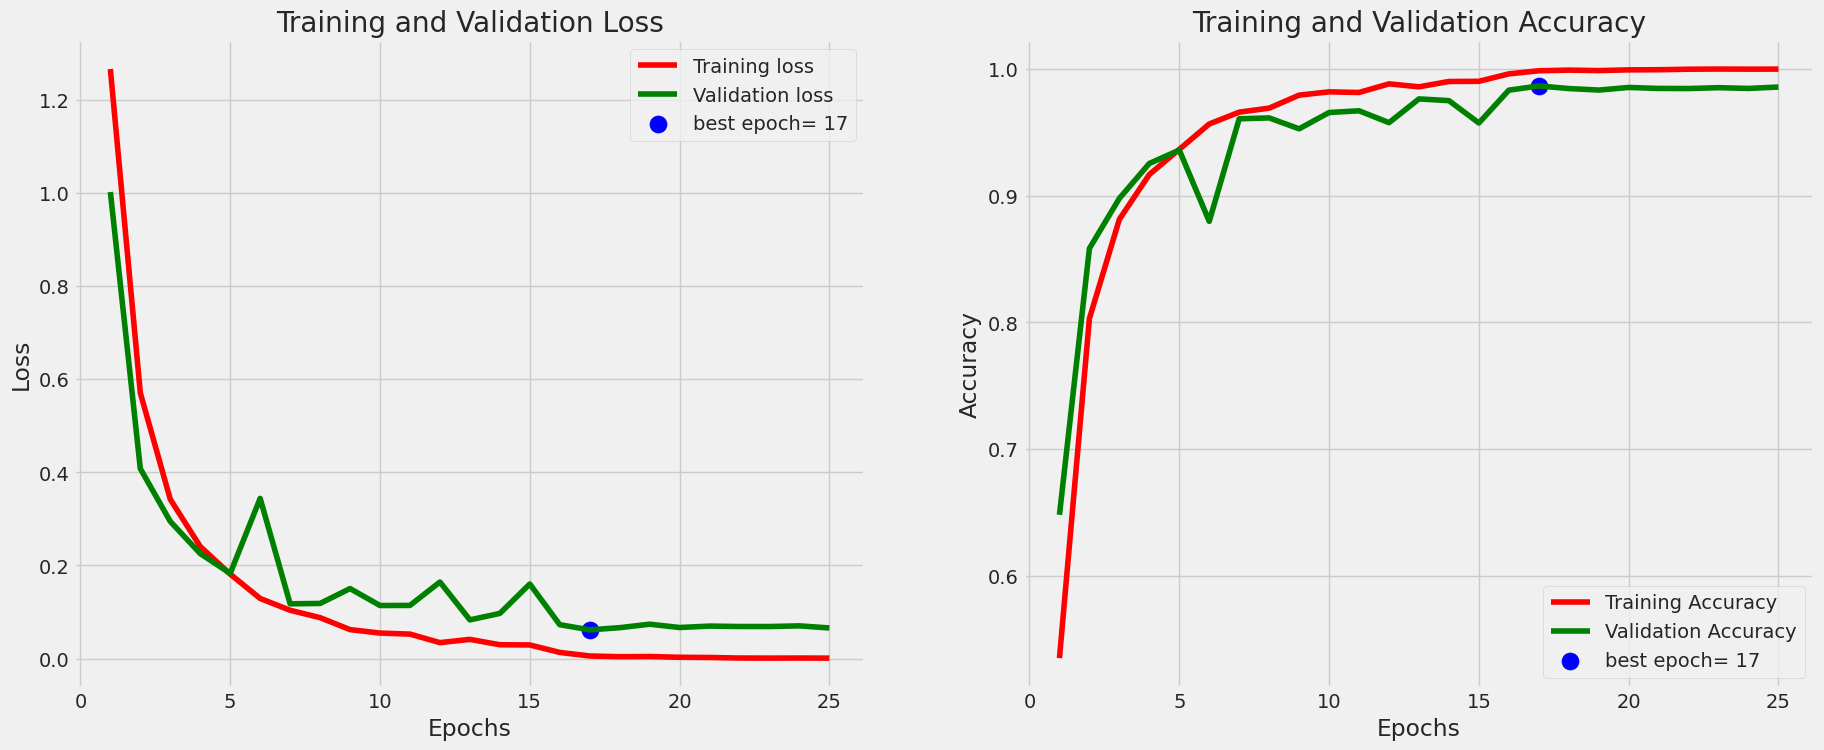

In [87]:
plot_training(history)

**CNN model evaluation**

In [88]:
train_score = model.evaluate(X_train, y_train, verbose= 1)
test_score = model.evaluate(X_test, y_test, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

367/367 [==============================] - 2s 4ms/step - loss: 0.0658 - accuracy: 0.9857
Train Loss:  0.000130542553961277
Train Accuracy:  1.0
--------------------
Test Loss:  0.06584981083869934
Test Accuracy:  0.9856826066970825


**Saving the model**

In [154]:
model.save('/content/drive/MyDrive/Skin HAM10000/output/my_model.h5')

Loading CNN model for RF classification

In [155]:
from tensorflow import keras
from keras.models import load_model

In [156]:
cnn_model = load_model('/content/drive/MyDrive/Skin HAM10000/output/my_model.h5')

In [157]:
import joblib

In [158]:
joblib.dump(cnn_model, '/content/drive/MyDrive/Skin HAM10000/output/cnn_model_skin.joblib')

['/content/drive/MyDrive/Skin HAM10000/output/cnn_model_skin.joblib']

In [159]:
from sklearn.ensemble import RandomForestClassifier

In [160]:
loaded_cnn_model = joblib.load('/content/drive/MyDrive/Skin HAM10000/output/cnn_model_skin.joblib')

In [161]:
X_train_features = loaded_cnn_model.predict(X_train)
X_test_features = loaded_cnn_model.predict(X_test)

367/367 [==============================] - 1s 2ms/step


In [162]:
X_train_features_flat = X_train_features.reshape(X_train_features.shape[0], -1)
X_test_features_flat = X_test_features.reshape(X_test_features.shape[0], -1)

In [163]:
X_train_features_flat.shape
X_test_features_flat.shape

(11734, 7)

In [164]:
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=0)
rf_classifier.fit(X_train_features_flat, y_train)

RandomForestClassifier(random_state=0)

In [165]:
# Make predictions using the trained Random Forest classifier
y_pred = rf_classifier.predict(X_test_features_flat)

In [166]:
y_pred.shape

(11734, 7)

# Model Evaluation

In [167]:
y_true = np.array(y_test)
y_pred = np.argmax(y_pred,axis=1)

In [168]:
y_true = np.argmax(y_true,axis=1)

In [169]:
print(y_pred.shape, y_true.shape)

(11734,) (11734,)


In [170]:
from sklearn.metrics import accuracy_score, classification_report

In [171]:
accuracy = accuracy_score(y_true, y_pred)
report = classification_report(y_true, y_pred)

In [172]:
print("Accuracy:", accuracy)
print("Classification Report:\n", report)

Accuracy: 0.9856826316686552
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1667
           1       0.99      1.00      1.00      1689
           2       0.97      0.99      0.98      1651
           3       1.00      1.00      1.00      1629
           4       0.98      0.92      0.95      1663
           5       1.00      1.00      1.00      1680
           6       0.95      0.99      0.97      1755

    accuracy                           0.99     11734
   macro avg       0.99      0.99      0.99     11734
weighted avg       0.99      0.99      0.99     11734



**Create classes labels**

In [173]:
classes_labels = []
for key in classes.keys():
    classes_labels.append(key)

print(classes_labels)

[4, 6, 2, 1, 5, 0, 3]


**Confussion Matrix**

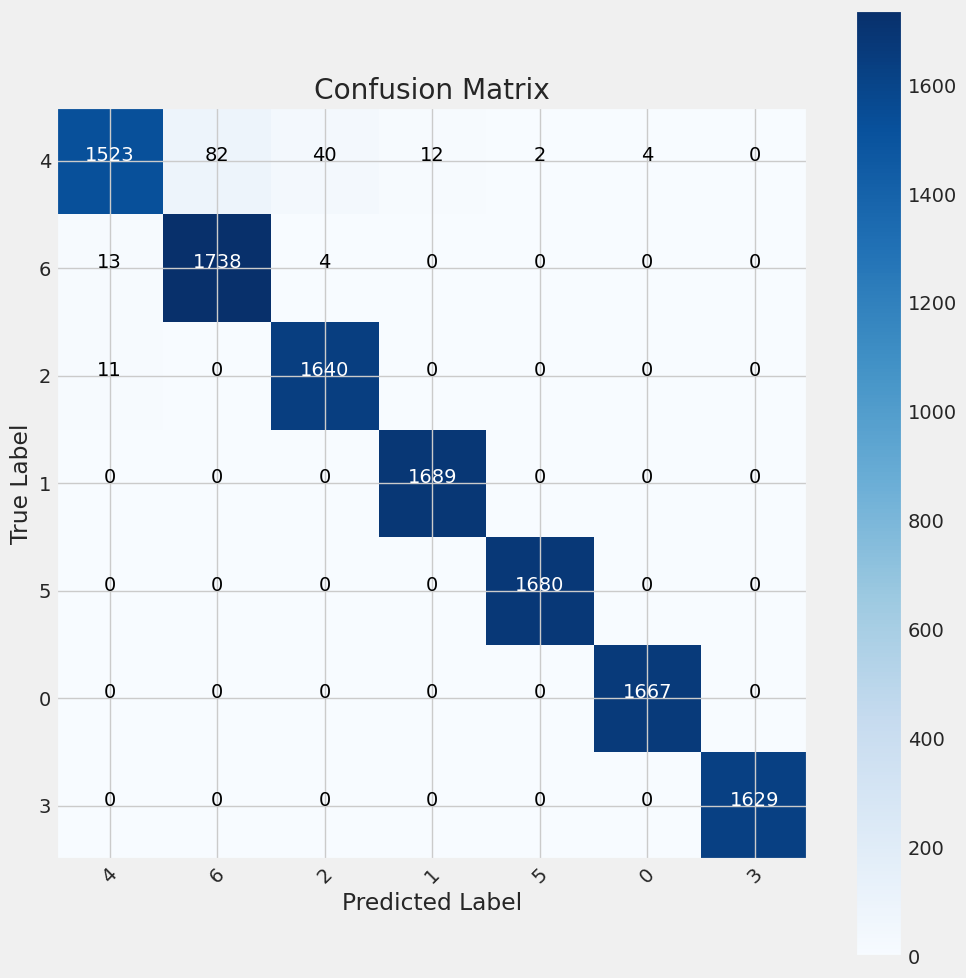

In [174]:
# Confusion matrix
cm = cm = confusion_matrix(y_true, y_pred, labels=classes_labels)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [175]:
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import cohen_kappa_score

mcc = matthews_corrcoef(y_true, y_pred)
kappa = cohen_kappa_score(y_true, y_pred)

print("Matthews Correlation Coefficient:", mcc)
print("Cohen's Kappa:", kappa)

Matthews Correlation Coefficient: 0.9833731179073527
Cohen's Kappa: 0.9832942158390107


# **ROC**

In [176]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize
y_true_binarized = label_binarize(y_true, classes=classes_labels)
y_pred_binarized = label_binarize(y_pred, classes=classes_labels)
print(y_true_binarized.shape)
print(y_pred_binarized.shape)

(11734, 7)
(11734, 7)


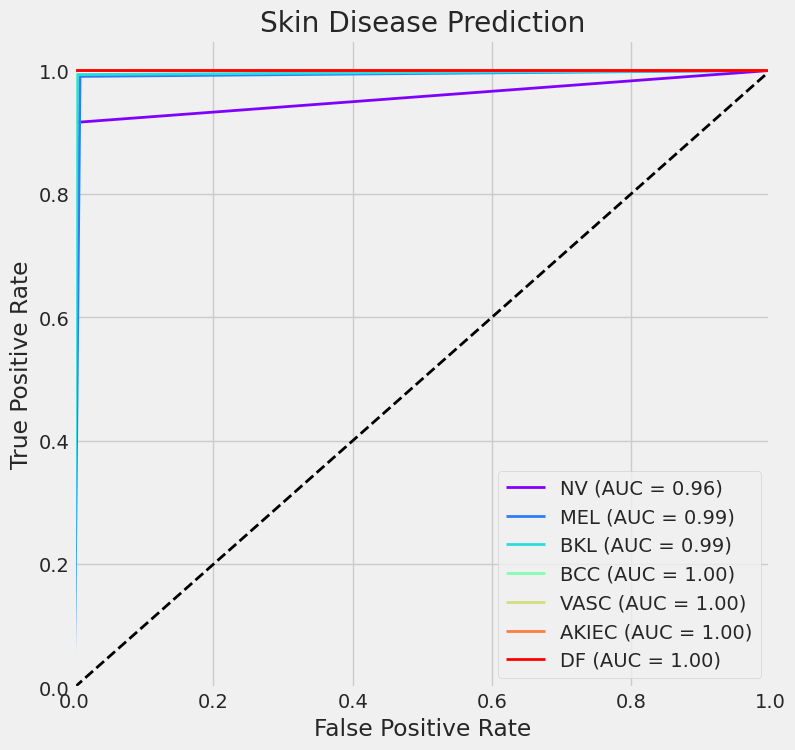

In [177]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(classes_labels)):
    fpr[i], tpr[i], _ = roc_curve(y_true_binarized[:, i], y_pred_binarized[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(8, 8))
colors = iter(plt.cm.rainbow(np.linspace(0, 1,len(classes_labels))))
for i, color in zip(range(len(classes_labels)), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='{0} (AUC = {1:0.2f})'
             ''.format(classes[classes_labels[i]][0].upper(), roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Skin Disease Prediction')
plt.legend(loc="lower right")
plt.show()

# **Grad CAM Visualization**

In [178]:
pip install tf-keras-vis

In [179]:
import matplotlib.cm as cm
cnn_model_for_gradcam=load_model('/content/drive/MyDrive/Skin HAM10000/output/my_model.h5')

In [180]:
last_conv_layer_name = "conv2d_13"
last_conv_layer_model = Model(inputs=cnn_model_for_gradcam.input, outputs=cnn_model_for_gradcam.get_layer(last_conv_layer_name).output)

In [181]:
meta_df = pd.read_csv('/content/drive/MyDrive/Skin HAM10000/HAM10000_metadata.csv')
unique_images = meta_df.groupby('dx')['image_id'].first().reset_index()
unique_images_values = unique_images.to_dict('records')
unique_images_values

[{'dx': 'akiec', 'image_id': 'ISIC_0029417'},
 {'dx': 'bcc', 'image_id': 'ISIC_0028155'},
 {'dx': 'bkl', 'image_id': 'ISIC_0027419'},
 {'dx': 'df', 'image_id': 'ISIC_0027008'},
 {'dx': 'mel', 'image_id': 'ISIC_0025964'},
 {'dx': 'nv', 'image_id': 'ISIC_0024698'},
 {'dx': 'vasc', 'image_id': 'ISIC_0031197'}]

In [191]:
def get_image_prediction(image_id):
  img_path = "/content/drive/MyDrive/Skin HAM10000/unique_images/"+ image_id + ".jpg"
  img = load_img(img_path, target_size=(28,28))
  img_array = img_to_array(img)
  img_array_expanded = np.expand_dims(img_array, axis=0)
  img_features = cnn_model_for_gradcam.predict(img_array_expanded)
  img_features_flat = img_features.reshape(img_features.shape[0], -1)
  predicted_output = rf_classifier.predict(img_features_flat)
  class_predicted = np.argmax(predicted_output, axis=1)[0]
  return img_array, class_predicted

def model_modifier(m):
    m.layers[-1].activation = tf.keras.activations.linear
    return m

def score_function(output):
    return output[0]

In [192]:
from tf_keras_vis.gradcam import Gradcam
gradcam = Gradcam(cnn_model_for_gradcam, model_modifier, clone=False)

In [193]:
from PIL import Image

def get_heatmap(dx, image_id):
  img_array, class_predicted = get_image_prediction(image_id)
  class_abbr_predicted = classes[class_predicted][0]

  heatmap = gradcam(score_function,
                    img_array,
                    penultimate_layer=-1, # the last convolutional layer
                    )
  # Normalize and map the heatmap to RGB
  heatmap_normalized = np.uint8(255 * heatmap)

  # Apply a colormap (like jet) to the heatmap
  heatmap_colored = np.uint8(cm.jet(heatmap_normalized)[..., :3] * 255)

  # Remove the singleton dimensions (if your heatmap has extra dimensions)
  heatmap_colored = np.squeeze(heatmap_colored)

  # Ensure the heatmap is of the correct shape (height, width, channels)
  if heatmap_colored.ndim != 3:
      raise ValueError("Heatmap is not a 3D array of shape (height, width, channels)")

  # Convert the colored heatmap to an Image object
  heatmap_image = Image.fromarray(heatmap_colored)

  # Resize the heatmap to match the original image size
  heatmap_resized = heatmap_image.resize(img_array.shape[:2], Image.ANTIALIAS)

  # Convert the resized heatmap to a numpy array
  heatmap_resized = np.array(heatmap_resized)

  # Superimpose the heatmap onto the original image
  superimposed_img = heatmap_resized * 0.4 + img_array

  original_pil = Image.fromarray(img_array.astype('uint8'))
  superimposed_pil = Image.fromarray(superimposed_img.astype('uint8'))

  # Create a new figure for plotting
  plt.figure(figsize=(12, 6))

  # Plot the original image
  plt.subplot(1, 2, 1)
  plt.imshow(original_pil)
  plt.title(f'Original Image\nTrue class: {dx}')
  plt.axis('off')

  # Plot the heatmap image
  plt.subplot(1, 2, 2)
  plt.imshow(superimposed_pil)
  plt.title(f'GRAD-CAM Class Activation\nPredicted class: {class_abbr_predicted}')
  plt.axis('off')

  # Adjust layout and display the plot
  plt.tight_layout()
  plt.show()

1/1 [==============================] - 0s 22ms/step


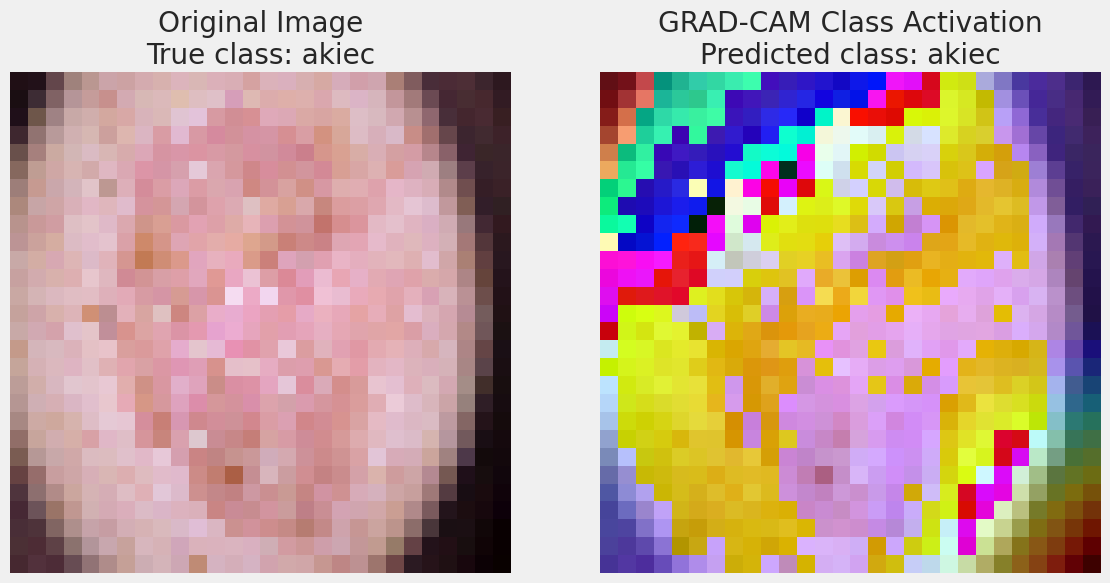

1/1 [==============================] - 0s 20ms/step


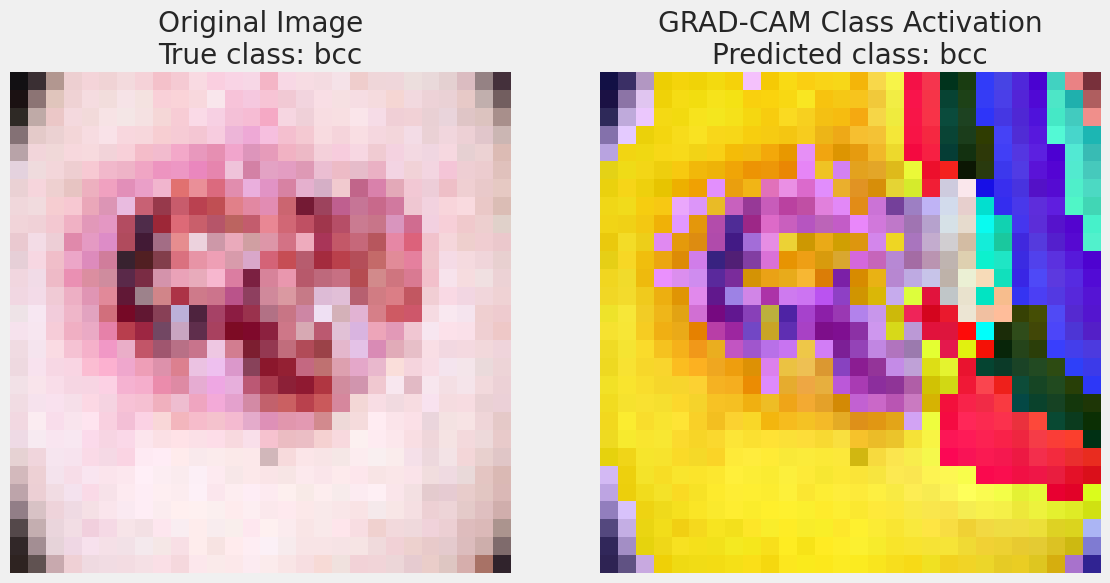

1/1 [==============================] - 0s 19ms/step


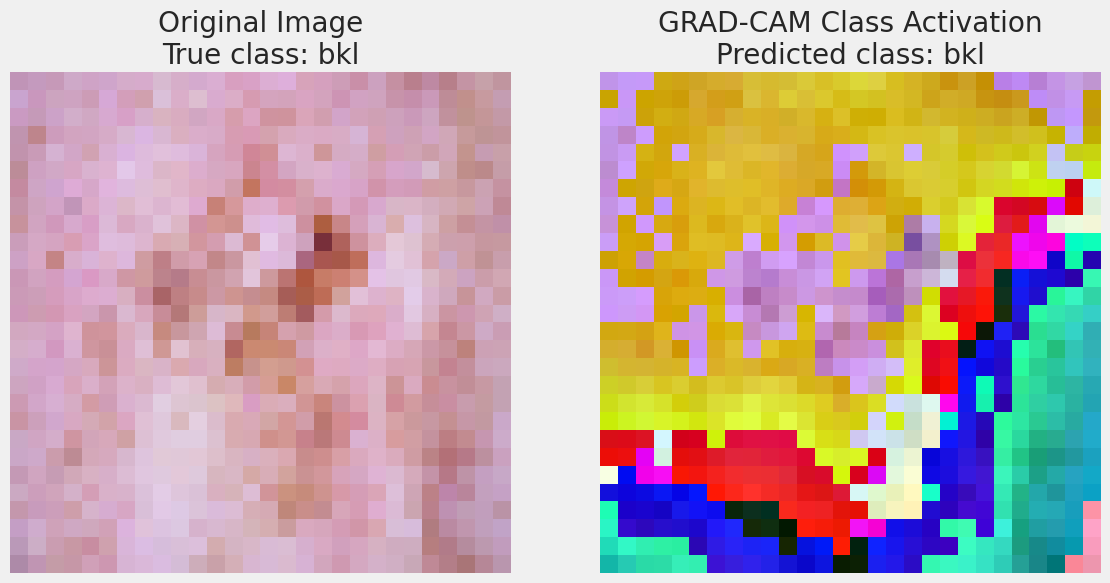

1/1 [==============================] - 0s 19ms/step


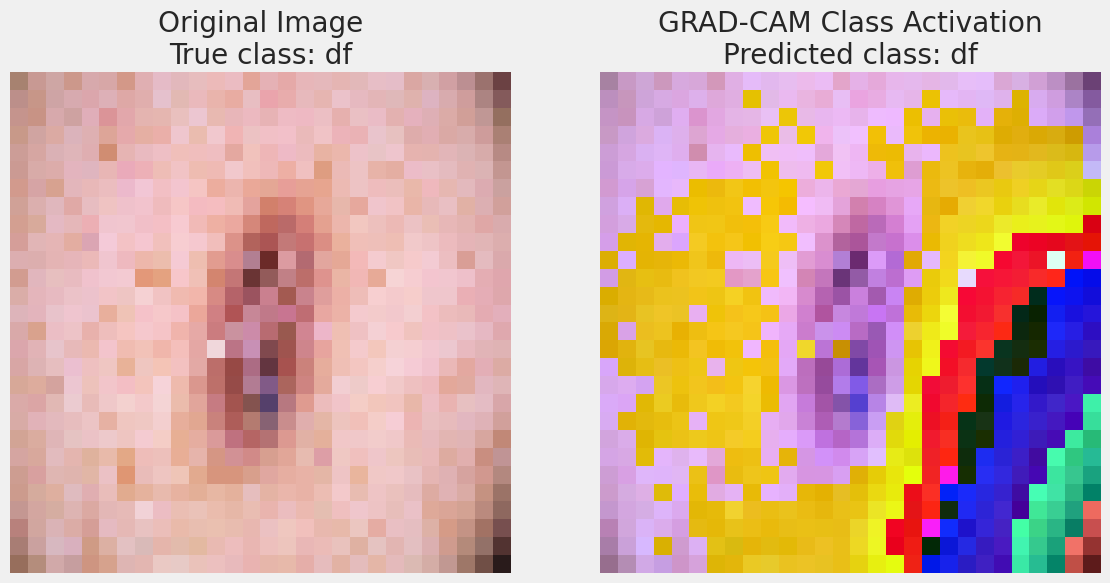

1/1 [==============================] - 0s 19ms/step


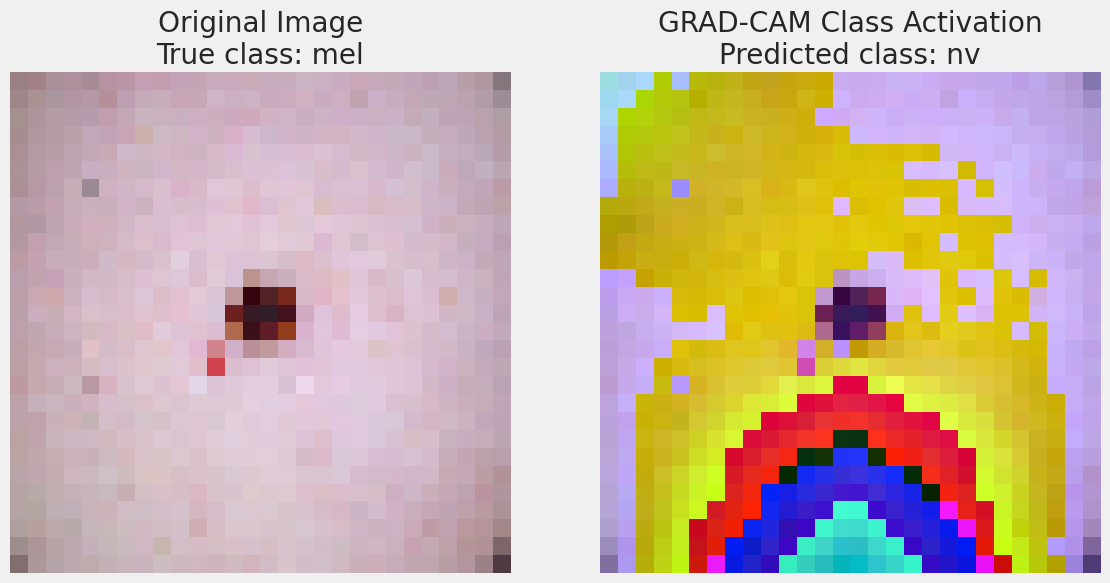

1/1 [==============================] - 0s 20ms/step


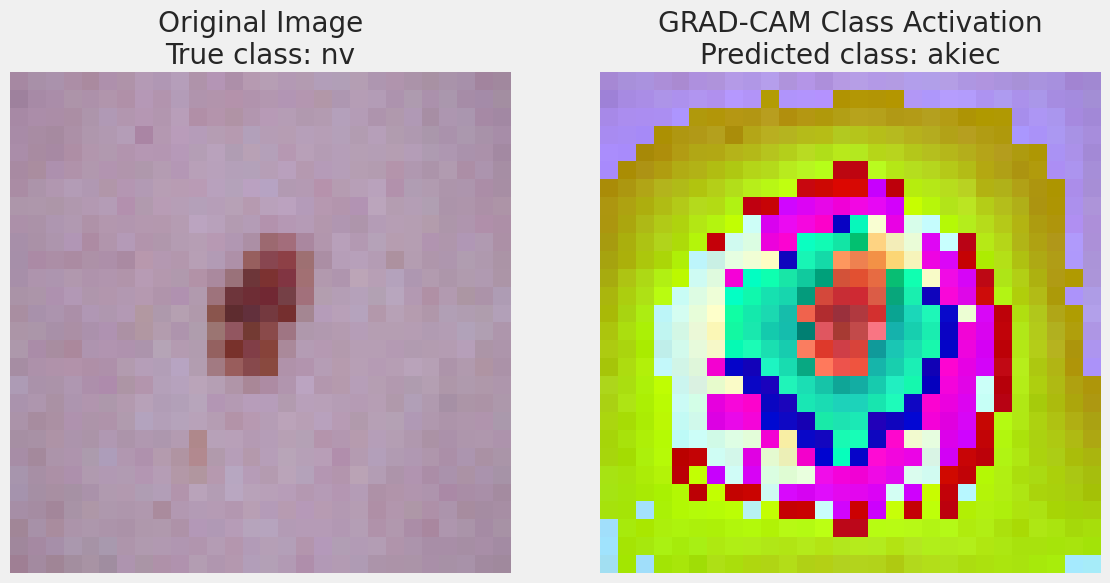

1/1 [==============================] - 0s 19ms/step


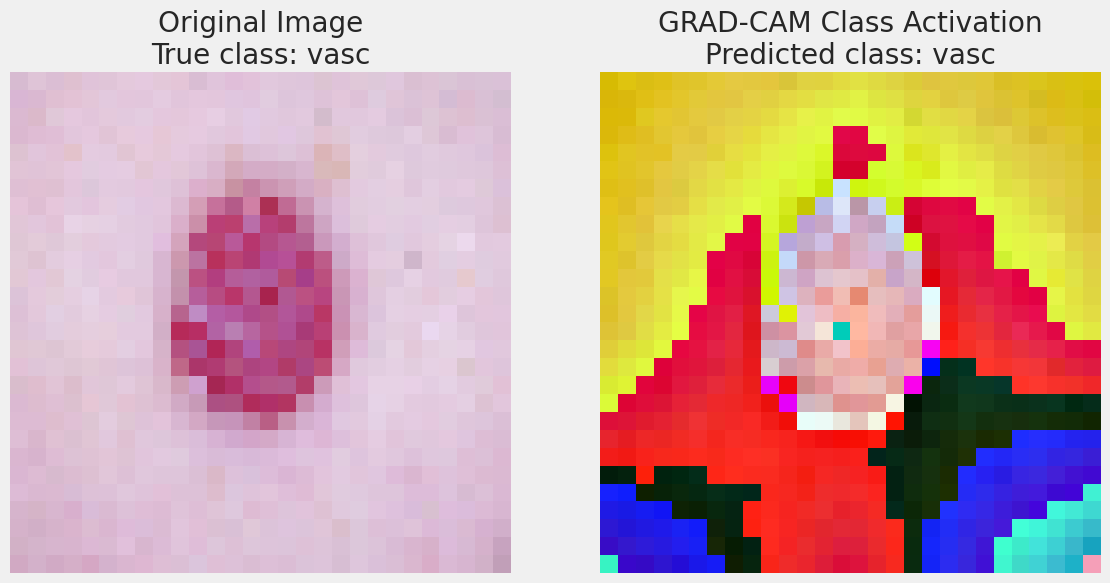

In [194]:
for image_info in unique_images_values:
    dx = image_info['dx']
    image_id = image_info['image_id']
    get_heatmap(dx, image_id)

# [{'dx': 'akiec', 'image_id': 'ISIC_0029417'},
#  {'dx': 'bcc', 'image_id': 'ISIC_0028155'},
#  {'dx': 'bkl', 'image_id': 'ISIC_0027419'},
#  {'dx': 'df', 'image_id': 'ISIC_0027008'},
#  {'dx': 'mel', 'image_id': 'ISIC_0025964'},
#  {'dx': 'nv', 'image_id': 'ISIC_0024698'},
#  {'dx': 'vasc', 'image_id': 'ISIC_0031197'}]
# classes = {4: ('nv', ' melanocytic nevi'),
#            6: ('mel', 'melanoma'),
#            2 :('bkl', 'benign keratosis-like lesions'),
#            1:('bcc' , ' basal cell carcinoma'),
#            5: ('vasc', ' pyogenic granulomas and hemorrhage'),
#            0: ('akiec', 'Actinic keratoses and intraepithelial carcinomae'),
#            3: ('df', 'dermatofibroma')}